In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# reflect the tables
# We can view all of the classes that automap found
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
# create a session
session = Session(engine)

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [16]:
# Earliest and Latest Dates
earliest_date = session.query(measurement.date).order_by(measurement.date).first()
dummy = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"The data range from {earliest_date[0]} to {dummy[0]}")

The data range from 2010-01-01 to 2017-08-23


In [17]:
#Last year of data
format_str = '%Y-%m-%d' # The format
datetime_obj = dt.datetime.strptime(dummy[0], format_str)
query_date = datetime_obj.date() - dt.timedelta(days=365) 
print(query_date)

2016-08-23


In [18]:
last_year_rain = session.query(measurement.date, measurement.station, measurement.prcp, measurement.tobs).\
    filter(measurement.date > query_date, ).order_by(measurement.date).all()

In [20]:
# Query Last year into DataFrame
conn = engine.connect()
import_df = pd.read_sql(f"SELECT date, station, prcp, tobs FROM measurement WHERE date > {query_date} ORDER BY date", conn)
import_df.tail()

,date,station,prcp,tobs
19545,2017-08-22,USC00516128,0.50,76.0
19546,2017-08-23,USC00519397,0.00,81.0
19547,2017-08-23,USC00514830,0.00,82.0
19548,2017-08-23,USC00519523,0.08,82.0
19549,2017-08-23,USC00516128,0.45,76.0


In [21]:
#Set date to index
last_year_measurements_df=import_df.set_index('date')
last_year_measurements_df.head()

,station,prcp,tobs
date,,,
2010-01-01,USC00519397,0.08,65.0
2010-01-01,USC00513117,0.28,67.0
2010-01-01,USC00518838,0.21,72.0
2010-01-01,USC00519523,0.15,75.0
2010-01-01,USC00519281,0.15,70.0


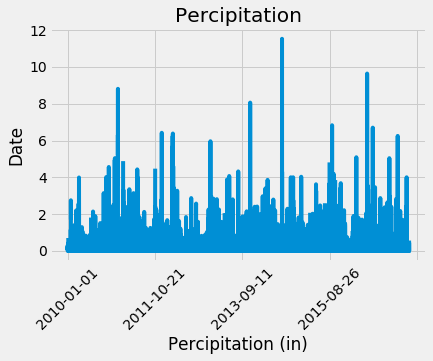

In [22]:
last_year_measurements_df["prcp"].plot()
plt.xticks(rotation= 45)
plt.xlabel('Percipitation (in)')
plt.ylabel('Date')
plt.title('Percipitation')
plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_measurements_df.describe()

,prcp,tobs
count,18103.000000,19550.000000
mean,0.160644,73.097954
std,0.468746,4.523527
min,0.000000,53.000000
25%,0.000000,70.000000
50%,0.010000,73.000000
75%,0.110000,76.000000
max,11.530000,87.000000


In [54]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(func.count(station.id)).all()

number = number_of_stations[0][0]
print(f"There are {number} weather stations")

There are 9 weather stations


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_list = session.query(measurement.station,func.count(measurement.tobs)).\
group_by(measurement.station).order_by(func.count(measurement.tobs).desc()).all()
active_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
active_station = str(active_list[0][0])
print(f"{active_station} is the most active weather station")

USC00519281 is the most active weather station


In [35]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest_temp = session.query(measurement.station,func.min(measurement.tobs)).filter(measurement.station == active_station).first()
highest_temp = session.query(measurement.station,func.max(measurement.tobs)).filter(measurement.station == active_station).first()
average_temp = session.query(measurement.station,func.avg(measurement.tobs)).filter(measurement.station == active_station).first()

print(f"The lowest temperature recorded was {lowest_temp[1]}F, the highest temperature recorded was {highest_temp[1]}F and the average temperature was {round(average_temp[1])}F at the {active_station} station")

The lowest temperature recorded was 54.0F, the highest temperature recorded was 85.0F and the average temperature was 72F at the USC00519281 station


In [31]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram date > '2016-08-23' AND 
#temp_import_df = pd.read_sql(f"SELECT date, station, tobs FROM measurement WHERE station == 'USC00519281' ORDER BY date", conn)
#temp_import_df.tail()

# Query Last year into DataFrame
temp_import_df = pd.read_sql(f"SELECT date, tobs FROM measurement WHERE date > {query_date} AND station = '{activest}' ORDER BY date", conn)
temp_import_df.tail()

,date,tobs
2767,2017-08-14,77.0
2768,2017-08-15,77.0
2769,2017-08-16,76.0
2770,2017-08-17,76.0
2771,2017-08-18,79.0


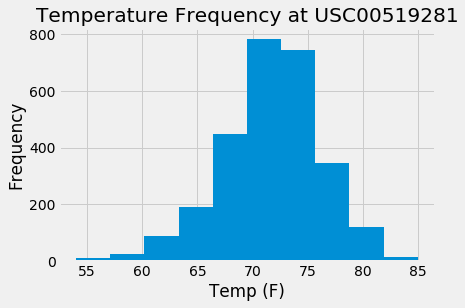

In [32]:
#Set date to index
last_year_temp_df=temp_import_df.set_index('date')
last_year_temp_df.head()

last_year_temp_df["tobs"].plot(kind = "hist")
plt.xlabel('Temp (F)')
plt.ylabel('Frequency')
plt.title('Temperature Frequency at USC00519281')
plt.show()


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
